<a href="https://colab.research.google.com/github/bhardwaj5671/FoodimagerocessingAnalysis/blob/main/food_image_clssification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d kmader/food41

Dataset URL: https://www.kaggle.com/datasets/kmader/food41
License(s): copyright-authors
100% 5.29G/5.30G [01:01<00:00, 43.7MB/s]
100% 5.30G/5.30G [01:01<00:00, 92.9MB/s]


In [5]:
!mkdir food41

In [6]:
! unzip food41.zip -d food41

Streaming output truncated to the last 5000 lines.
  inflating: food41/images/tacos/1026681.jpg  
  inflating: food41/images/tacos/1030289.jpg  
  inflating: food41/images/tacos/1033196.jpg  
  inflating: food41/images/tacos/1036030.jpg  
  inflating: food41/images/tacos/1042175.jpg  
  inflating: food41/images/tacos/1044043.jpg  
  inflating: food41/images/tacos/1058697.jpg  
  inflating: food41/images/tacos/1059239.jpg  
  inflating: food41/images/tacos/1059326.jpg  
  inflating: food41/images/tacos/1066762.jpg  
  inflating: food41/images/tacos/1070967.jpg  
  inflating: food41/images/tacos/1073468.jpg  
  inflating: food41/images/tacos/1075296.jpg  
  inflating: food41/images/tacos/1085243.jpg  
  inflating: food41/images/tacos/108529.jpg  
  inflating: food41/images/tacos/1086014.jpg  
  inflating: food41/images/tacos/108945.jpg  
  inflating: food41/images/tacos/1089575.jpg  
  inflating: food41/images/tacos/1091159.jpg  
  inflating: food41/images/tacos/1101369.jpg  
  inflating

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [8]:
image_dir = Path('/content/food41/images')

In [9]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
image_df

,Filepath,Label
0,/content/food41/images/gnocchi/2346211.jpg,gnocchi
1,/content/food41/images/strawberry_shortcake/16...,strawberry_shortcake
2,/content/food41/images/cup_cakes/2267298.jpg,cup_cakes
3,/content/food41/images/samosa/1986940.jpg,samosa
4,/content/food41/images/crab_cakes/2497137.jpg,crab_cakes
...,...,...
10095,/content/food41/images/chocolate_mousse/108427...,chocolate_mousse
10096,/content/food41/images/dumplings/405415.jpg,dumplings
10097,/content/food41/images/garlic_bread/3708596.jpg,garlic_bread
10098,/content/food41/images/baby_back_ribs/2709715.jpg,baby_back_ribs


In [12]:
image_df['Label'].value_counts()

Label
gnocchi           100
churros           100
carrot_cake       100
lobster_bisque    100
beignets          100
                 ... 
sashimi           100
falafel           100
escargots         100
chocolate_cake    100
fish_and_chips    100
Name: count, Length: 101, dtype: int64

In [13]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [14]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [15]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


In [16]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [18]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
177/177 [==============================] - 315s 2s/step - loss: 3.7990 - accuracy: 0.1480 - val_loss: 2.9451 - val_accuracy: 0.2822
Epoch 2/100
177/177 [==============================] - 275s 2s/step - loss: 2.3580 - accuracy: 0.4013 - val_loss: 2.5312 - val_accuracy: 0.3607
Epoch 3/100
177/177 [==============================] - 323s 2s/step - loss: 1.8000 - accuracy: 0.5311 - val_loss: 2.3183 - val_accuracy: 0.3911
Epoch 4/100
177/177 [==============================] - 294s 2s/step - loss: 1.4070 - accuracy: 0.6238 - val_loss: 2.3855 - val_accuracy: 0.4024
Epoch 5/100
177/177 [==============================] - 293s 2s/step - loss: 1.1073 - accuracy: 0.7019 - val_loss: 2.4136 - val_accuracy: 0.4109
Epoch 6/100
177/177 [==============================] - 277s 2s/step - loss: 0.8544 - accuracy: 0.7714 - val_loss: 2.4260 - val_accuracy: 0.4173


In [19]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

95/95 [==============================] - 123s 1s/step


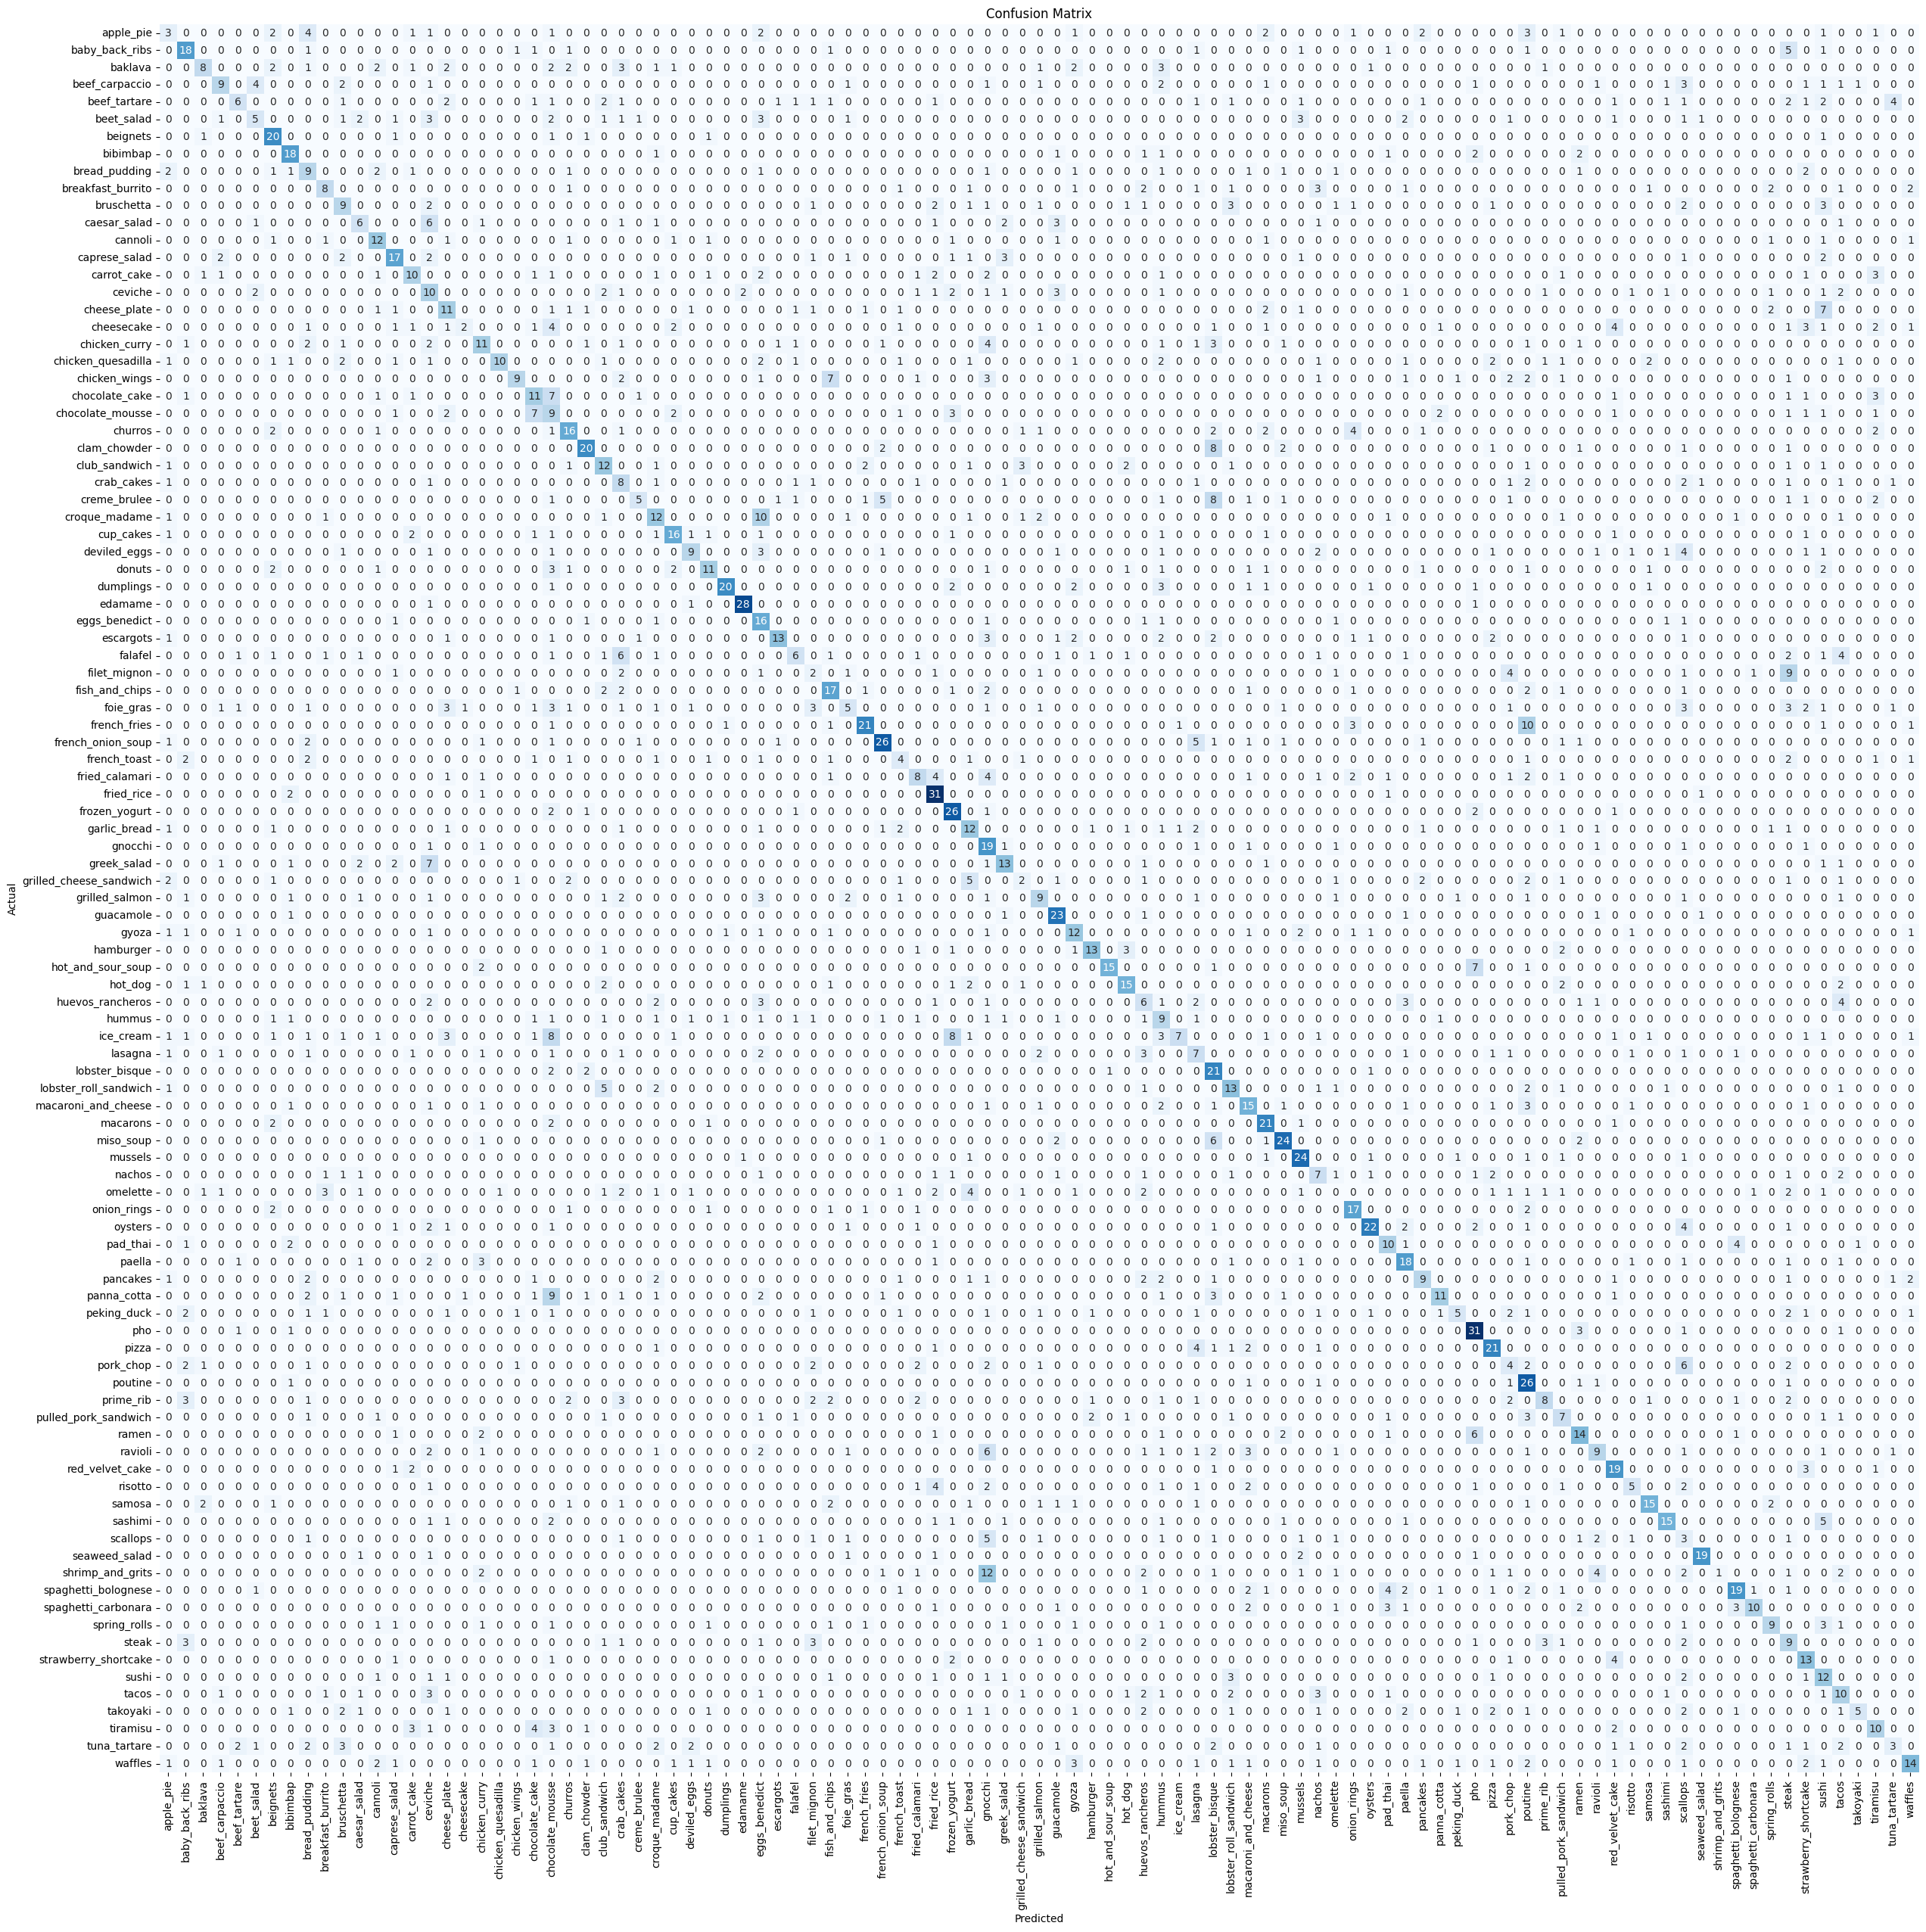

In [20]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.14      0.12      0.13        26
         baby_back_ribs       0.49      0.55      0.51        33
                baklava       0.53      0.24      0.33        33
         beef_carpaccio       0.47      0.28      0.35        32
           beef_tartare       0.46      0.17      0.25        35
             beet_salad       0.36      0.16      0.22        31
               beignets       0.49      0.77      0.60        26
               bibimbap       0.56      0.67      0.61        27
          bread_pudding       0.25      0.33      0.29        27
      breakfast_burrito       0.47      0.31      0.37        26
             bruschetta       0.33      0.30      0.32        30
           caesar_salad       0.33      0.25      0.29        24
                cannoli       0.44      0.50      0.47        24
          caprese_salad       0.50      0.